# Random forest

In [2]:
from textblob import TextBlob
import nltk
from collections import Counter
import re
from textblob import download_corpora
#run this in the terminal : python -m textblob.download_corpora 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/todorovkatia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 0. Data prep


In [3]:
import pandas as pd
import numpy as n
import pickle
import re
from pathlib import Path
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""
root = Path(__file__).resolve().parent if "__file__" in globals() else Path.cwd()
while root.parent != root:
    if ((root / ".git").exists() and 
        (root / "README.txt").exists() and 
        (root / "results.ipynb").exists()): break
    root = root.parent
if str(root) not in sys.path: sys.path.insert(0, str(root))

print("Root folder at: ", root)"""

# Detect root starting from this file or from notebook’s cwd
try:
    start_path = Path(__file__).resolve()
except NameError:
    start_path = Path.cwd()

root = start_path
while root != root.parent:
    # Check for any known project markers
    if any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
        break
    root = root.parent

# Sanity check — fallback if nothing found
if not any((root / marker).exists() for marker in [".git", "README.md", "results.ipynb", "README.txt"]):
    print("⚠️ Project root not found — defaulting to current working directory")
    root = Path.cwd()

print(f"✅ Root folder detected at: {root}")

# Add project root to sys.path if not already
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from src.utils.paths import *
from src.utils.general_utils import *

stored_dataprep_pkl_path = root / STORED_DATAPREP_PKL_PATH
with open(stored_dataprep_pkl_path, "rb") as f:
    data = pickle.load(f)

✅ Root folder detected at: /Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/ada-2025-project-adacore42


In [3]:
dataA = data['dataA']
dfs_with_id = [
    df.assign(source_id=i)   # ajoute une colonne avec l’indice du DF
    for i, df in enumerate(dataA)
]

# Concaténation des DataFrames
dataAm2 = pd.concat(dfs_with_id, ignore_index=True)

display(dataAm2)

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,source_id
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74,0
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78,0
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23,0
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19,0
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52,0
...,...,...,...,...,...,...,...,...,...
2292673,Looks like we took a wrong turn at the Hubble ...,1.023256,0.016347,86,84,2,0,-8.46,383
2292674,Post-modern just doesn't do it for me.,1.022222,0.015625,90,88,2,0,-8.57,383
2292675,How was I supposed to know they covered themse...,1.020833,0.014654,96,94,2,0,-8.72,383
2292676,"No, they wanted us to teleport the giveaway ca...",1.020619,0.020619,97,96,0,1,-8.84,383


In [ ]:
#14min de run crazy
"""results_blob = []
#subset_test_rf =dataAm2.loc[30000:100000,] 
for cap in dataAm2['caption']:
    blob = TextBlob(cap)
    results_blob.append({
        'caption': cap,
        'tags': blob.tags,
        'words': blob.words,
        'num_words' : len(blob.words),
        'adjectives': [w for w, pos in blob.tags if pos.startswith("JJ")],
        'proper_nouns': [w for w, pos in blob.tags if pos == "NNP"],
        'num_proper_nouns' : len([w for w, pos in blob.tags if pos == "NNP"]),
        'num_verbs' : len([w for w, pos in blob.tags if pos.startswith("VB")]),
        'polarity': blob.sentiment.polarity, #sentiment entre -1 (négatif) et +1 (positif).
        'subjectivity': blob.sentiment.subjectivity, #Valeur entre 0 (objectif) et 1 (subjectif).
        'num_punct' : len(re.findall(r'[^\w\s]', cap)),
        'num_repeats' : len( re.findall(r'\b(\w+)\s+\1\b', cap.lower()))
        #'sentences': [str(s) for s in blob.sentences],
        #'nouns': blob.noun_phrases,
        #'verbs': [w.lower() for w, pos in blob.tags if pos.startswith("VB")],
        #'adverbs': [w for w, pos in blob.tags if pos.startswith("RB")],
        #'lemmas': [w.lemmatize() for w in blob.words], # pour comparer mot meme si pluriel
        #'word_counts': blob.word_counts,
        #'ngrams_2': blob.ngrams(2) # analyse mot ensemble
    })

# Convertir en DataFrame pour analyses
df_blob = pd.DataFrame(results_blob)

dataAm_rf = dataAm2.merge(df_blob, on="caption", how="left")
dataAm_rf"""
#dataAm_rf.to_csv("/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/code_perso/dataAm_rf.csv", index=True)


,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,source_id,tags,words,num_words,adjectives,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats
0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74,0,"[(I, PRP), ('m, VBP), (a, DT), (congressman, N...","[I, 'm, a, congressman, obstruction, is, my, job]",8,[],[],0,2,0.000000,0.000000,4,0
1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78,0,"[(I, PRP), ('m, VBP), (what, WP), (they, PRP),...","[I, 'm, what, they, mean, when, they, say, 'Th...",15,[middle],[],0,6,-0.156250,0.343750,5,0
2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23,0,"[(Does, VBZ), (this, DT), (suit, NN), (make, V...","[Does, this, suit, make, me, look, flat]",7,[flat],[],0,3,-0.025000,0.125000,1,0
3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19,0,"[(When, WRB), (the, DT), (right, JJ), (woman, ...","[When, the, right, woman, comes, along, I, 'll...",10,[right],[],0,2,0.285714,0.535714,3,0
4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52,0,"[(I, PRP), (used, VBD), (to, TO), (lie, VB), (...","[I, used, to, lie, in, the, gutter, but, then,...",12,[],[],0,4,0.000000,0.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513773,Looks like we took a wrong turn at the Hubble ...,1.023256,0.016347,86,84,2,0,-8.46,383,"[(Looks, NNS), (like, IN), (we, PRP), (took, V...","[Looks, like, we, took, a, wrong, turn, at, th...",12,"[wrong, Hubble]","[Deep, Field]",2,1,-0.250000,0.650000,0,0
2513774,Post-modern just doesn't do it for me.,1.022222,0.015625,90,88,2,0,-8.57,383,"[(Post-modern, JJ), (just, RB), (does, VBZ), (...","[Post-modern, just, does, n't, do, it, for, me]",8,[Post-modern],[],0,2,0.000000,0.000000,3,0
2513775,How was I supposed to know they covered themse...,1.020833,0.014654,96,94,2,0,-8.72,383,"[(How, WRB), (was, VBD), (I, PRP), (supposed, ...","[How, was, I, supposed, to, know, they, covere...",20,[naked],[Macy],1,7,0.000000,0.450000,6,0
2513776,"No, they wanted us to teleport the giveaway ca...",1.020619,0.020619,97,96,0,1,-8.84,383,"[(No, DT), (they, PRP), (wanted, VBD), (us, PR...","[No, they, wanted, us, to, teleport, the, give...",16,[],"[Macy, ’]",2,2,0.000000,0.000000,3,0


In [4]:
dataAm_rf = pd.read_csv("/Users/todorovkatia/Documents/EPFL/MA3/ADA/Projet/code_perso/dataAm_rf.csv")

,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,source_id,tags,words,num_words,adjectives,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats
67364,So....what type of business did you say you we...,1.388235,0.069197,85,59,19,7,-1.86,13,"[(So, RB), (...., VB), (what, WP), (type, NN),...","[So, what, type, of, business, did, you, say, ...",172,"[least, more, little, intense, new, much, long...","[Well, Planet, Apes, Planet, Apes, BluRay, Sha...",15,31,0.174697,0.501837,62,0
68818,They just finished downloading everything Shak...,1.230769,0.075783,52,43,6,3,-4.28,13,"[(They, PRP), (just, RB), (finished, VBD), (do...","[They, just, finished, downloading, everything...",243,"[more, sorry, right, much, mine, urban, least,...","[Shakespeare, Monroe, County, Movers, Monkey, ...",14,51,0.164286,0.330075,105,0
69108,Monkeys don't breed well in captivity...yea ri...,1.212121,0.059191,66,54,10,2,-4.65,13,"[(Monkeys, NNS), (do, VBP), (n't, RB), (breed,...","[Monkeys, do, n't, breed, well, in, captivity,...",454,"[more, fun, wrong, sure, d, ‘, catchier, last,...","[Planet, Apes, ’, Pre-typing, Costco, Wrong, B...",40,92,0.157351,0.353532,219,0
69499,Why couldn't it be a barrel of chocolates? Or ...,1.187500,0.064249,48,40,7,1,-4.66,13,"[(Why, WRB), (could, MD), (n't, RB), (it, PRP)...","[Why, could, n't, it, be, a, barrel, of, choco...",380,"[monkey, eleven, open, least, better, more, ha...","[Chippendale, Swingers, Just, 'widdle, Let, Br...",19,80,0.092873,0.319540,186,0
70427,I warned you that no good would come of tellin...,1.120000,0.046423,50,44,6,0,-5.74,13,"[(I, PRP), (warned, VBD), (you, PRP), (that, I...","[I, warned, you, that, no, good, would, come, ...",244,"[good, least, rid, more, military, sure, empty...","[Clarence, Darrow, Donkeys, IN, Honey, Go, NFL...",11,51,0.152352,0.412812,115,0
70948,I TOLD you they'd take after your side of the ...,1.062500,0.043476,32,30,2,0,-6.01,13,"[(I, PRP), (TOLD, VBP), (you, PRP), (they, PRP...","[I, TOLD, you, they, 'd, take, after, your, si...",181,"[Emotional, monkey, good, hard, original, much]","[Banana, Support, Animals, Amazon, Did, Invita...",6,41,0.066601,0.420503,75,0
71154,I told you if you didn't get ECHO out of the B...,1.032258,0.032791,31,30,1,0,-6.43,13,"[(I, PRP), (told, VBD), (you, PRP), (if, IN), ...","[I, told, you, if, you, did, n't, get, ECHO, o...",235,"[more, uncle, monkey, barrel, new, other, luck...","[ECHO, BEDROOM, Golden, Retriever, Family, Pac...",23,44,0.063344,0.317252,102,0
1263643,Red Sam came in and told his wife to quit loun...,1.206349,0.068480,63,54,5,4,-4.98,199,"[(Red, JJ), (Sam, NNP), (came, VBD), (in, IN),...","[Red, Sam, came, in, and, told, his, wife, to,...",115,"[Red, s, t, t, red, gray, ’]","[Sam, Ain, ’]",3,18,0.288889,0.217778,23,0
1288584,"I began to feel resigned to my fate, and as I ...",1.333333,0.042651,204,151,38,15,-3.44,202,"[(I, PRP), (began, VBD), (to, TO), (feel, VB),...","[I, began, to, feel, resigned, to, my, fate, a...",106,"[same, clear, firm, last]",[God],1,25,-0.020000,0.195000,9,0
1291474,"I just love our childfree life, spending our S...",1.172840,0.054969,81,71,6,4,-5.82,202,"[(I, PRP), (just, RB), (love, VB), (our, PRP$)...","[I, just, love, our, childfree, life, spending...",111,"[childfree, nice, ”, ⠀, serious, much, next, ....","[Me, Jimmy, Phelps, ”, ⠀, ⠀, “, Parents, ⠀, “,...",20,20,0.073810,0.523810,28,0


'Our case looks grim.'

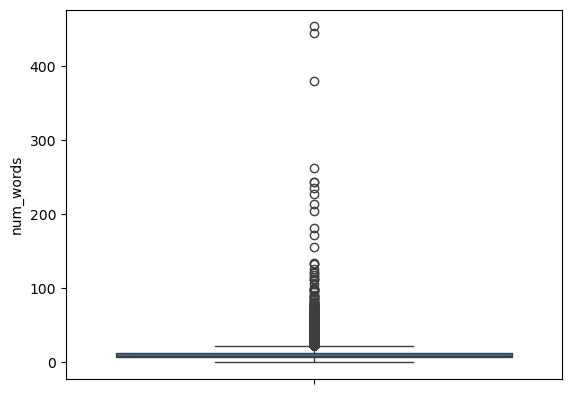

In [47]:
sns.boxplot(dataAm_rf["num_words"])
display(dataAm_rf[dataAm_rf["num_words"]>=100])
#
dataAm_rf.iloc[34141]["caption"]

In [5]:
# remove outliers
dataAm_rf_clean = dataAm_rf[dataAm_rf["num_words"]<=80]


In [6]:
print(dataAm_rf.shape)
dataAm_rf_clean

(2513778, 21)


,Unnamed: 0,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,source_id,...,words,num_words,adjectives,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats
0,0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74,0,...,"['I', ""'m"", 'a', 'congressman', 'obstruction',...",8,[],[],0,2,0.000000,0.000000,4,0
1,1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78,0,...,"['I', ""'m"", 'what', 'they', 'mean', 'when', 't...",15,['middle'],[],0,6,-0.156250,0.343750,5,0
2,2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23,0,...,"['Does', 'this', 'suit', 'make', 'me', 'look',...",7,['flat'],[],0,3,-0.025000,0.125000,1,0
3,3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19,0,...,"['When', 'the', 'right', 'woman', 'comes', 'al...",10,['right'],[],0,2,0.285714,0.535714,3,0
4,4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52,0,...,"['I', 'used', 'to', 'lie', 'in', 'the', 'gutte...",12,[],[],0,4,0.000000,0.000000,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513773,2513773,Looks like we took a wrong turn at the Hubble ...,1.023256,0.016347,86,84,2,0,-8.46,383,...,"['Looks', 'like', 'we', 'took', 'a', 'wrong', ...",12,"['wrong', 'Hubble']","['Deep', 'Field']",2,1,-0.250000,0.650000,0,0
2513774,2513774,Post-modern just doesn't do it for me.,1.022222,0.015625,90,88,2,0,-8.57,383,...,"['Post-modern', 'just', 'does', ""n't"", 'do', '...",8,['Post-modern'],[],0,2,0.000000,0.000000,3,0
2513775,2513775,How was I supposed to know they covered themse...,1.020833,0.014654,96,94,2,0,-8.72,383,...,"['How', 'was', 'I', 'supposed', 'to', 'know', ...",20,['naked'],['Macy'],1,7,0.000000,0.450000,6,0
2513776,2513776,"No, they wanted us to teleport the giveaway ca...",1.020619,0.020619,97,96,0,1,-8.84,383,...,"['No', 'they', 'wanted', 'us', 'to', 'teleport...",16,[],"['Macy', '’']",2,2,0.000000,0.000000,3,0


In [40]:
#add type of question mark 
def get_question_type(question):
        question = question.lower().strip()
        match = re.match(r"(why|what|how|who|where|when|is|are|does|do|can|could|would|should)", question)
        return match.group(0) if match else "other"

In [ ]:
dataAm_rf_clean.loc[:, "category"] = np.where(dataAm_rf_clean['funny_score'] > 0, 'funny', 'unfunny')
df_majority = dataAm_rf_clean[dataAm_rf_clean['category'] == 'unfunny']
df_minority = dataAm_rf_clean[dataAm_rf_clean['category'] == 'funny']
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)

In [42]:
df_balanced = df_balanced.copy()  # pour éviter SettingWithCopyWarning

df_balanced["question_type"] = df_balanced["words"].apply(get_question_type)

In [43]:
df_balanced

,Unnamed: 0,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,source_id,...,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats,funny_score_log,category,question_type
530242,530242,You know you're going to have to inform all yo...,1.608059,0.031758,546,299,162,85,2.68,90,...,"['Muffin', 'Man']",2,7,-0.166667,0.166667,3,0,3.101443,funny,other
558062,558062,Hey! Get your own selfie-portrait.,1.219298,0.042727,114,91,21,2,-4.97,93,...,[],0,1,0.600000,1.000000,3,0,2.679651,unfunny,other
2228370,2228370,I think we can forget the tails.,1.583070,0.018324,1583,888,467,228,2.47,337,...,[],0,2,0.000000,0.000000,1,0,3.091951,funny,other
1215718,1215718,Looks like someone really did take the A train,1.524246,0.025910,763,463,200,100,0.64,194,...,['A'],1,2,0.200000,0.200000,0,0,3.005187,funny,other
1598588,1598588,"I know, it's not the job we expected...they fl...",1.162500,0.048535,80,69,9,2,-5.80,238,...,[],0,4,0.000000,0.000000,5,0,2.621039,unfunny,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634386,1634386,"Sorry, I'm early.",1.590909,0.051602,198,109,61,28,1.99,243,...,['Sorry'],1,1,-0.200000,0.650000,3,0,3.069912,funny,other
1833830,1833830,"I'm not boring you, am I?",1.524851,0.031430,503,301,140,62,0.72,269,...,[],0,3,0.500000,1.000000,3,0,3.009142,funny,other
1467597,1467597,Psst—the salad says its olive oil is the only ...,1.768720,0.012028,4367,2001,1375,991,8.43,223,...,['Psst—the'],1,2,0.000000,1.000000,2,0,3.331490,funny,other
2420990,2420990,No more games. One of you needs to pay the dam...,1.537074,0.030952,499,288,154,57,1.17,369,...,[],0,2,-0.250000,0.500000,2,0,3.031099,funny,other


## 2. Initialization RF

In [46]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = df_balanced[['num_words',
        "polarity",
        "subjectivity",
        'num_proper_nouns',
        'num_verbs',
        'num_repeats',
         'num_punct' ]]  
y = df_balanced["category"]  # variable continue ou category

# Split 80/20
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split trainval en train et validation
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.3, random_state=42
)

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
results = []

for depth in [ 2, 4, 8]:
    for n in [50, 100 ,200]:
        model = RandomForestClassifier(
            max_depth=depth,
            n_estimators=n,
            random_state=42
        )

        model.fit(X_train, y_train)

        # score sur validation
        y_pred = model.predict(X_val)
        #mse = mean_squared_error(y_val, y_pred)
        acc = accuracy_score(y_val, y_pred)
        f1  = f1_score(y_val, y_pred, pos_label="funny")  # si labels 'funny'/'unfunny'


        results.append((depth, n,acc,f1 ))#mse si continuous
        print(f"end trial on {depth} and {n} trees")

results

end trial on 2 and 50 trees
end trial on 2 and 100 trees
end trial on 2 and 200 trees
end trial on 4 and 50 trees
end trial on 4 and 100 trees
end trial on 4 and 200 trees
end trial on 8 and 50 trees
end trial on 8 and 100 trees
end trial on 8 and 200 trees


[(2, 50, 0.5538707352987249, 0.6335374954964229),
 (2, 100, 0.5537140887872427, 0.6332483715661286),
 (2, 200, 0.5536201008803534, 0.6324803962030541),
 (4, 50, 0.555374541808954, 0.6257778715325387),
 (4, 100, 0.5548732729722109, 0.6254547371750936),
 (4, 200, 0.5557504934365112, 0.6262716778240472),
 (8, 50, 0.5612017920360913, 0.6059753558768919),
 (8, 100, 0.562893574360099, 0.6061649635860668),
 (8, 200, 0.562893574360099, 0.6094064949608062)]

In [51]:
best = max(results, key=lambda x: x[2])
best

(8, 100, 0.562893574360099, 0.6061649635860668)

## 3. Train model

In [54]:

best_model = RandomForestClassifier(
    max_depth=best[0],
    n_estimators=best[1],
    random_state=42
)

best_model.fit(X_trainval, y_trainval)

y_test_pred = best_model.predict(X_test)


"""MSE =  mean_squared_error(y_test, y_test_pred)
print("MSE :",MSE) # faire mean sqaure error  ou mean absolute error
r2=r2_score(y_test, y_test_pred)
print("R² :", r2) # faire mean sqaure error  ou mean absolute error
if r2>0.3 : 
    print(f"Bravo c'est déjà quelquechose ma queen, r2 = {r2}")
else : 
    print(f"Ich c'est pas de ouf concluant, r2 = {r2}")"""
acc = accuracy_score(y_test, y_test_pred)
f1  = f1_score(y_test, y_test_pred, pos_label="funny")  # si labels 'funny'/'unfunny'
print(acc)
print(f1)


0.5647744360902256
0.6028337164225188


In [55]:
import numpy as np 
"""y_pred_train = best_model.predict(X_trainval)
y_pred_test = best_model.predict(X_test)
r2_train = r2_score(y_trainval, y_pred_train)
r2_test = r2_score(y_test, y_pred_test) 
rmse_train = np.sqrt(mean_squared_error(y_trainval, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"Train R²: {r2_train:.3f}, RMSE: {rmse_train:.3f}")
print(f"Test R²: {r2_test:.3f}, RMSE: {rmse_test:.3f}")""" #Pour regressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# prédictions
y_pred_train = best_model.predict(X_trainval)
y_pred_test = best_model.predict(X_test)

# accuracy
acc_train = accuracy_score(y_trainval, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"Train Accuracy: {acc_train:.3f}")
print(f"Test Accuracy:  {acc_test:.3f}")

# autres métriques utiles
print("\nClassification report (test set):")
print(classification_report(y_test, y_pred_test))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_test))


Train Accuracy: 0.573
Test Accuracy:  0.565

Classification report (test set):
              precision    recall  f1-score   support

       funny       0.56      0.66      0.60     13397
     unfunny       0.57      0.47      0.52     13203

    accuracy                           0.56     26600
   macro avg       0.57      0.56      0.56     26600
weighted avg       0.57      0.56      0.56     26600


Confusion matrix:
[[8786 4611]
 [6966 6237]]


In [37]:

importances = best_model.feature_importances_
feature_names =X_trainval.columns
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': X_trainval.columns,
    'Importance': importances
})

# Tri des caractéristiques par importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,num_words,0.337352
3,num_proper_nouns,0.229202
6,num_punct,0.130981
1,polarity,0.116449
4,num_verbs,0.105375
2,subjectivity,0.077928
5,num_repeats,0.002712


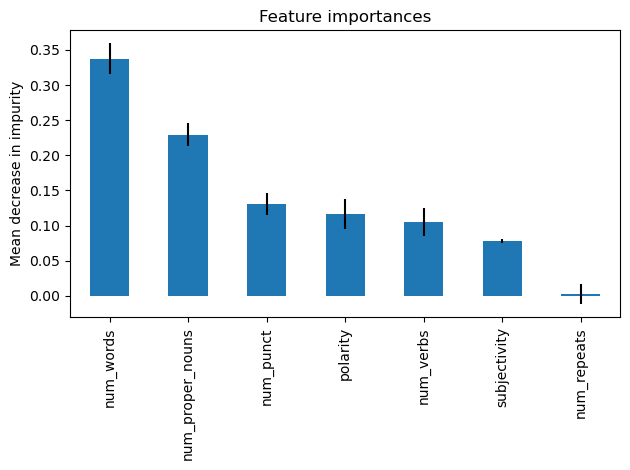

In [38]:
forest_importances = pd.Series(importances, index=feature_names)
forest_importances_sorted = forest_importances.sort_values(ascending=False)
fig, ax = plt.subplots()
forest_importances_sorted.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Exploration pk ca marche pas ma gueule

Most likely pcq on a vraiment moins de la class drole ducoup il arrive pas a learn dessus
Solution : Downsampler un peu le unfun pcq on a quand meme 67127 funny 

In [28]:
dataAm_rf_clean.loc[:, "category"] = np.where(dataAm_rf_clean['funny_score'] > 0, 'funny', 'unfunny')
dataAm_rf_clean.head()

,Unnamed: 0,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,source_id,...,adjectives,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats,funny_score_log,category
0,0,I'm a congressman--obstruction is my job.,1.913043,0.094022,69,24,27,18,6.74,0,...,[],[],0,2,0.000000,0.000000,4,0,3.269189,funny
1,1,"I'm what they mean when they say, 'The middle ...",1.842105,0.191381,19,8,6,5,3.78,0,...,['middle'],[],0,6,-0.156250,0.343750,5,0,3.149740,funny
2,2,Does this suit make me look flat?,1.711111,0.112915,45,21,16,8,3.23,0,...,['flat'],[],0,3,-0.025000,0.125000,1,0,3.125883,funny
3,3,"When the right woman comes along, I'll know it.",1.625000,0.116657,32,15,14,3,2.19,0,...,['right'],[],0,2,0.285714,0.535714,3,0,3.079154,funny
4,4,"I used to lie in the gutter, but then I quit d...",1.617647,0.133610,34,19,9,6,1.52,0,...,[],[],0,4,0.000000,0.000000,2,0,3.047850,funny


In [ ]:
dataAm_rf_clean.loc[:, "category"] = np.where(dataAm_rf_clean['funny_score'] > 0, 'funny', 'unfunny')
df_majority = dataAm_rf_clean[dataAm_rf_clean['category'] == 'unfunny']
df_minority = dataAm_rf_clean[dataAm_rf_clean['category'] == 'funny']
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)


In [30]:
df_balanced

,Unnamed: 0,caption,mean,precision,votes,not_funny,somewhat_funny,funny,funny_score,source_id,...,adjectives,proper_nouns,num_proper_nouns,num_verbs,polarity,subjectivity,num_punct,num_repeats,funny_score_log,category
530242,530242,You know you're going to have to inform all yo...,1.608059,0.031758,546,299,162,85,2.68,90,...,['previous'],"['Muffin', 'Man']",2,7,-0.166667,0.166667,3,0,3.101443,funny
558062,558062,Hey! Get your own selfie-portrait.,1.219298,0.042727,114,91,21,2,-4.97,93,...,['own'],[],0,1,0.600000,1.000000,3,0,2.679651,unfunny
2228370,2228370,I think we can forget the tails.,1.583070,0.018324,1583,888,467,228,2.47,337,...,[],[],0,2,0.000000,0.000000,1,0,3.091951,funny
1215718,1215718,Looks like someone really did take the A train,1.524246,0.025910,763,463,200,100,0.64,194,...,[],['A'],1,2,0.200000,0.200000,0,0,3.005187,funny
1598588,1598588,"I know, it's not the job we expected...they fl...",1.162500,0.048535,80,69,9,2,-5.80,238,...,[],[],0,4,0.000000,0.000000,5,0,2.621039,unfunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1634386,1634386,"Sorry, I'm early.",1.590909,0.051602,198,109,61,28,1.99,243,...,['early'],['Sorry'],1,1,-0.200000,0.650000,3,0,3.069912,funny
1833830,1833830,"I'm not boring you, am I?",1.524851,0.031430,503,301,140,62,0.72,269,...,[],[],0,3,0.500000,1.000000,3,0,3.009142,funny
1467597,1467597,Psst—the salad says its olive oil is the only ...,1.768720,0.012028,4367,2001,1375,991,8.43,223,...,"['olive', 'only']",['Psst—the'],1,2,0.000000,1.000000,2,0,3.331490,funny
2420990,2420990,No more games. One of you needs to pay the dam...,1.537074,0.030952,499,288,154,57,1.17,369,...,"['more', 'damned']",[],0,2,-0.250000,0.500000,2,0,3.031099,funny


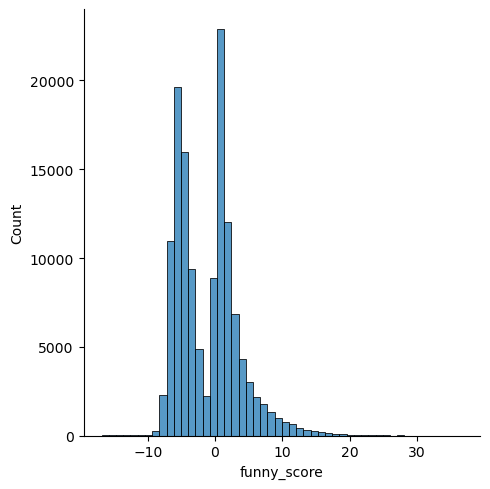

In [31]:

sns.displot(df_balanced, x="funny_score", bins=50)